In [1]:
import kagglehub

# Herunterladen des Spam - Ham Datensatzes
path = kagglehub.dataset_download("venky73/spam-mails-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/spam-mails-dataset


In [2]:
import pandas as pd

# Passe den Dateinamen an, falls er anders ist
dataset_file = path + '/spam_ham_dataset.csv'

df = pd.read_csv(dataset_file)

# Anzeigen der ersten Zeilen des DataFrames, um zu überprüfen, ob es korrekt geladen wurde
print(df.head())

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


In [3]:
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Vorbereiten der Daten
texts = df['text'].tolist()
labels = df['label'].tolist()

# Encodieren der Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels) # 0 für ham, 1 für spam

# Aufteilen des Datensatzes
train_texts, test_texts, train_labels, test_labels = train_test_split(texts,
                                                                      encoded_labels,
                                                                      test_size=0.2,
                                                                      random_state=42)

In [4]:
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers, processors

# Erstellen des Tokenizers mit den gewünschten Parameter und normalisierung
tokenizer = Tokenizer(models.WordLevel(unk_token="[UNK]"))
tokenizer.normalizer = normalizers.Lowercase()
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Trainieren der Tokenizierung.
trainer = trainers.WordLevelTrainer(special_tokens=["[UNK]"])
tokenizer.train_from_iterator(train_texts, trainer=trainer)

vocab_size = tokenizer.get_vocab_size()

# Enkodieren der Texte
train_sequences = [tokenizer.encode(text).ids for text in train_texts]
test_sequences = [tokenizer.encode(text).ids for text in test_texts]

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Input, Dropout, LSTM, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Tokenisierung und Padding
EMBEDDING_DIM = 32
MAX_SEQUENCE_LENGTH = 512

train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Erstellen des Modells
def build_token_embedding_model():
    return Sequential([
        Input(shape=(MAX_SEQUENCE_LENGTH,)),
        Embedding(vocab_size, EMBEDDING_DIM),
        GlobalAveragePooling1D(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
model = build_token_embedding_model()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 512, 32)        │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961,089 (3.67 MB)

 Trainable params: 961,089 (3.67 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
EPOCHS = 10

history = model.fit(train_padded,
                    train_labels,
                    epochs=EPOCHS,
                    validation_data=(test_padded, test_labels))

loss, accuracy = model.evaluate(test_padded, test_labels, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6893 - loss: 0.6194 - val_accuracy: 0.7179 - val_loss: 0.5445
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7093 - loss: 0.5441 - val_accuracy: 0.7256 - val_loss: 0.4763
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7520 - loss: 0.4778 - val_accuracy: 0.8908 - val_loss: 0.4234
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8149 - loss: 0.4053 - val_accuracy: 0.8077 - val_loss: 0.3389
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8765 - loss: 0.2973 - val_accuracy: 0.9536 - val_loss: 0.2168
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9045 - loss: 0.2349 - val_accuracy: 0.8812 - val_loss: 0.2241
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9369 - loss: 0.1715 - val_accuracy: 0.8483 - val_loss: 0.2929
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9233 - loss: 0.1999 - val_accu

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


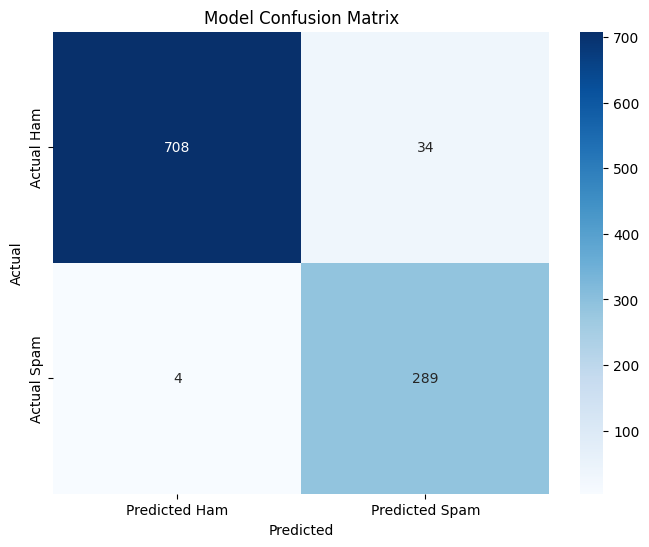

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Vorhersagen auf dem Testset machen mit dem trainierten TensorFlow-Modell
# Da es sich um ein binäres Klassifikationsmodell mit Sigmoid-Output handelt,
# erhalten wir Wahrscheinlichkeiten. Wir müssen diese in Klassen umwandeln.
y_pred_proba = model.predict(test_padded)
y_pred = (y_pred_proba > 0.5).astype("int32") # Konvertieren der Wahrscheinlichkeiten in 0 oder 1

# Die wahren Test-Labels sind in test_labels gespeichert

# Berechnen der Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# Anzeigen der Confusion Matrix als Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title("Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [8]:
!pip install gensim

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences

# Tokenisieren der Texte in Listen von Wörtern
tokenized_train_texts = [text.split() for text in train_texts]
tokenized_test_texts = [text.split() for text in test_texts]

# Trainieren Des Word2Vec-Modell
# min_count=1 bedeutet, dass wir Wörter mit mindestens einer Erscheinung berücksichtigen
# window=5 ist die Kontextfenstergröße
# workers ist die Anzahl der Threads, die für das Training verwendet werden
# sg=0 bedeutet, dass wir das CBOW-Modell verwenden (sg=1 würde Skip-gram verwenden)
word2vec_model = Word2Vec(sentences=tokenized_train_texts, vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4, sg=0)

# Konvertieren Sie die tokenisierten Trainings- und Testtexte in Listen von Word2Vec-Vektoren
# Jede Sequenz wird zu einer Liste von Word2Vec-Vektoren
train_word2vec_vectors = [[word2vec_model.wv[word] for word in seq if word in word2vec_model.wv] for seq in tokenized_train_texts]
test_word2vec_vectors = [[word2vec_model.wv[word] for word in seq  if word in word2vec_model.wv] for seq in tokenized_test_texts]

train_word2vec_vectors_padded = pad_sequences(train_word2vec_vectors, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post', truncating='post')
test_word2vec_vectors_padded = pad_sequences(test_word2vec_vectors, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32', padding='post', truncating='post')

# Das Eingabe-Shape ist nun (max_len, word2vec_embedding_dim)
def build_word2vec_model():
    return Sequential([
        Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM,)),
        Dense(8, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

model_w2v = build_word2vec_model()

model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_w2v.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512, 8)         │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,361 (17.04 KB)

 Trainable params: 4,361 (17.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7061 - loss: 0.6654 - val_accuracy: 0.9043 - val_loss: 0.2398
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8948 - loss: 0.2696 - val_accuracy: 0.9188 - val_loss: 0.1998
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9352 - loss: 0.1791 - val_accuracy: 0.9246 - val_loss: 0.1923
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9354 - loss: 0.1646 - val_accuracy: 0.9382 - val_loss: 0.1698
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9435 - loss: 0.1502 - val_accuracy: 0.9440 - val_loss: 0.1663
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9513 - loss: 0.1286 - val_accuracy: 0.9449 - val_loss: 0.1699
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9530 - loss: 0.1162 - val_accuracy: 0.9440 - val_loss: 0.1635
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9604 - loss: 0.1133 - val_accu

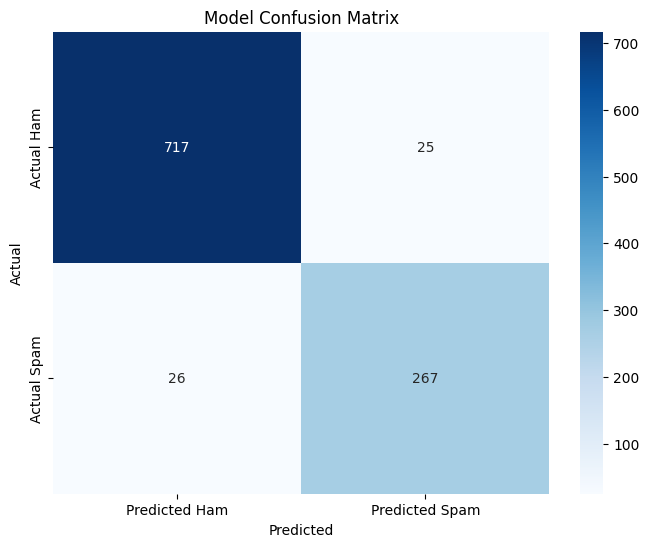

In [10]:
EPOCHS = 10

# Trainieren des Modells
history = model_w2v.fit(train_word2vec_vectors_padded,
                    train_labels,
                    epochs=EPOCHS,
                    validation_data=(test_word2vec_vectors_padded, test_labels))

# Evaluieren des Modells
loss, accuracy = model_w2v.evaluate(test_word2vec_vectors_padded, test_labels, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

y_pred_proba = model_w2v.predict(test_word2vec_vectors_padded)
y_pred = (y_pred_proba > 0.5).astype("int32") # Convert probabilities to 0 or 1

# Berechnen der Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# Anzeigen der Confusion Matrix als Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title("Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [12]:
from sklearn.model_selection import KFold
import numpy as np

# K-fold Cross-Validation für das erste Modell (mit Padding)
# Anzahl der Folds definieren
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Listen zur Speicherung der Metriken für jeden Fold
accuracy_scores_padded = []
recall_scores_padded = []
precision_scores_padded = []

# Schleife über die Folds
for fold, (train_index, val_index) in enumerate(kf.split(train_padded, train_labels)):
    print(f"--- Fold {fold+1}/{n_splits} für das erste Modell ---")

    # Daten für den aktuellen Fold aufteilen
    X_train_fold, X_val_fold = train_padded[train_index], train_padded[val_index]
    y_train_fold, y_val_fold = np.array(train_labels)[train_index], np.array(train_labels)[val_index] # Ensure labels are numpy array

    # Modell für jeden Fold neu erstellen, um sicherzustellen, dass es mit frischen Gewichten beginnt
    model = build_token_embedding_model()

    # Modell kompilieren
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Modell trainieren
    history = model.fit(X_train_fold,
                        y_train_fold,
                        epochs=EPOCHS, # Verwenden Sie die zuvor definierte Anzahl von Epochen
                        validation_data=(X_val_fold, y_val_fold),
                        verbose=0) # verbose=0 unterdrückt die Ausgabe des Trainingsfortschritts

    # Vorhersagen auf dem Validierungsset machen
    y_pred_proba_fold = model.predict(X_val_fold)
    y_pred_fold = (y_pred_proba_fold > 0.5).astype("int32")

    # Metriken berechnen und speichern
    accuracy_scores_padded.append(accuracy_score(y_val_fold, y_pred_fold))
    recall_scores_padded.append(recall_score(y_val_fold, y_pred_fold))
    precision_scores_padded.append(precision_score(y_val_fold, y_pred_fold))

# Durchschnittliche Metriken über alle Folds berechnen und ausgeben
print(f"\nDurchschnittliche Genauigkeit (Embedding Modell): {np.mean(accuracy_scores_padded):.4f}")
print(f"Durchschnittlicher Recall (Embedding Modell): {np.mean(recall_scores_padded):.4f}")
print(f"Durchschnittlicher Precision (Embedding Modell): {np.mean(precision_scores_padded):.4f}")

# K-fold Cross-Validation für das zweite Modell (mit Word2Vec)
# Listen zur Speicherung der Metriken für jeden Fold
accuracy_scores_w2v = []
recall_scores_w2v = []
precision_scores_w2v = []

# Convert padded word2vec vectors to numpy array
train_word2vec_vectors_padded_np = np.array(train_word2vec_vectors_padded)
test_word2vec_vectors_padded_np = np.array(test_word2vec_vectors_padded)

# Schleife über die Folds
for fold, (train_index, val_index) in enumerate(kf.split(train_word2vec_vectors_padded_np, train_labels)):
    print(f"\n--- Fold {fold+1}/{n_splits} für das zweite Modell ---")

    # Daten für den aktuellen Fold aufteilen
    X_train_fold_w2v, X_val_fold_w2v = train_word2vec_vectors_padded_np[train_index], train_word2vec_vectors_padded_np[val_index]
    y_train_fold_w2v, y_val_fold_w2v = np.array(train_labels)[train_index], np.array(train_labels)[val_index] # Ensure labels are numpy array

    # Modell für jeden Fold neu erstellen
    model_w2v = build_word2vec_model()

    # Modell kompilieren
    model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Modell trainieren
    history_w2v = model_w2v.fit(X_train_fold_w2v,
                              y_train_fold_w2v,
                              epochs=EPOCHS, # Verwenden Sie die zuvor definierte Anzahl von Epochen
                              validation_data=(X_val_fold_w2v, y_val_fold_w2v),
                              verbose=0) # verbose=0 unterdrückt die Ausgabe des Trainingsfortschritts

    # Vorhersagen auf dem Validierungsset machen
    y_pred_proba_fold_w2v = model_w2v.predict(X_val_fold_w2v)
    y_pred_fold_w2v = (y_pred_proba_fold_w2v > 0.5).astype("int32")

    # Metriken berechnen und speichern
    accuracy_scores_w2v.append(accuracy_score(y_val_fold_w2v, y_pred_fold_w2v))
    recall_scores_w2v.append(recall_score(y_val_fold_w2v, y_pred_fold_w2v))
    precision_scores_w2v.append(precision_score(y_val_fold_w2v, y_pred_fold_w2v))

# Durchschnittliche Metriken über alle Folds berechnen und ausgeben
print(f"\nDurchschnittliche Genauigkeit (Word2Vec Modell): {np.mean(accuracy_scores_w2v):.4f}")
print(f"Durchschnittlicher Recall (Word2Vec Modell): {np.mean(recall_scores_w2v):.4f}")
print(f"Durchschnittliche Precision (Word2Vec Modell): {np.mean(precision_scores_w2v):.4f}")

--- Fold 1/5 für das erste Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
--- Fold 2/5 für das erste Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
--- Fold 3/5 für das erste Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
--- Fold 4/5 für das erste Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
--- Fold 5/5 für das erste Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Durchschnittliche Genauigkeit (Embedding Modell): 0.9524
Durchschnittlicher Recall (Embedding Modell): 0.8899
Durchschnittlicher Precision (Embedding Modell): 0.9463

--- Fold 1/5 für das zweite Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

--- Fold 2/5 für das zweite Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Fold 3/5 für das zweite Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Fold 4/5 für das zweite Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Fold 5/5 für das zweite Modell ---
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Durchschnittliche Genauigkeit (Word2Vec Modell): 0.